In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Idea
Create the diagonal of the fock matrix via nn, then use gwh to create rest of the fock matrix

# Data 

In [2]:
data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"
subfolder = "EmbeddedBlocks/"

#data_path = "../../../cc2ai/ethen/"
#postfix = "_ethen_6-31g**"
#dim = 48
#N_ELECTRONS = 16
#basis = "6-31g**"

#data_path = "../thesis/dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(S))
ind = 0


molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test, p_test = S.reshape(-1, dim, dim), P.reshape(-1, dim, dim)

In [4]:
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

f_test = fock_from_density_batch(p_test)

In [5]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

# Calculate classical Guesses 

In [6]:
from pyscf.scf import hf

In [7]:
p_gwh = [
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]

# GWH Scheme

TODO: decide on the best k!

In [8]:
from SCFInitialGuess.utilities.dataset import density_from_fock

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)


In [9]:
from SCFInitialGuess.construction.fock import gwh_scheme

def gwh_scheme_wrapper(M, k=1.75):
    F = []
    for m, s in zip(M, s_test):
        F.append(gwh_scheme(np.diag(m), s, k))
        
    return np.array(F)

In [10]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(gwh_scheme_wrapper(h_test)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-03 09:56:01: Iteration calculation: 0
[ ] 2019-01-03 09:56:03: Iteration calculation: 1
[ ] 2019-01-03 09:56:05: Iteration calculation: 2
[ ] 2019-01-03 09:56:06: Iteration calculation: 3
[ ] 2019-01-03 09:56:08: Iteration calculation: 4
[ ] 2019-01-03 09:56:09: Iteration calculation: 5
[ ] 2019-01-03 09:56:11: Iteration calculation: 6
[ ] 2019-01-03 09:56:12: Iteration calculation: 7
[ ] 2019-01-03 09:56:14: Iteration calculation: 8
[ ] 2019-01-03 09:56:15: Iteration calculation: 9
[ ] 2019-01-03 09:56:16: Iteration calculation: 10
[ ] 2019-01-03 09:56:18: Iteration calculation: 11
[ ] 2019-01-03 09:56:19: Iteration calculation: 12
[ ] 2019-01-03 09:56:23: Iteration calculation: 13
[ ] 2019-01-03 09:56:25: Iteration calculation: 14
[ ] 2019-01-03 09:56:28: Iteration calculation: 15
[ ] 2019-01-03 09:56:29: Iteration calculation: 16
[ ] 2019-01-03 09:56:31: Iteration calculation: 17
[ ] 2019-01-03 09:56:33: Iteration calculation: 18
[ ] 2019-01-03 09:56:34: Iteration calcul

[ ] 2019-01-03 10:00:23: Iteration calculation: 160
[ ] 2019-01-03 10:00:26: Iteration calculation: 161
[ ] 2019-01-03 10:00:29: Iteration calculation: 162
[ ] 2019-01-03 10:00:30: Iteration calculation: 163
[ ] 2019-01-03 10:00:31: Iteration calculation: 164
[ ] 2019-01-03 10:00:33: Iteration calculation: 165
[ ] 2019-01-03 10:00:35: Iteration calculation: 166
[ ] 2019-01-03 10:00:35: Iteration calculation: 167
[ ] 2019-01-03 10:00:38: Iteration calculation: 168
[ ] 2019-01-03 10:00:39: Iteration calculation: 169
[ ] 2019-01-03 10:00:41: Iteration calculation: 170
[ ] 2019-01-03 10:00:43: Iteration calculation: 171
[ ] 2019-01-03 10:00:44: Iteration calculation: 172
[ ] 2019-01-03 10:00:45: Iteration calculation: 173
[ ] 2019-01-03 10:00:47: Iteration calculation: 174
[ ] 2019-01-03 10:00:49: Iteration calculation: 175
[ ] 2019-01-03 10:00:50: Iteration calculation: 176
[ ] 2019-01-03 10:00:52: Iteration calculation: 177
[ ] 2019-01-03 10:00:53: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 10:04:28: Iteration calculation: 318
[ ] 2019-01-03 10:04:28: Iteration calculation: 319
[ ] 2019-01-03 10:04:30: Iteration calculation: 320
[ ] 2019-01-03 10:04:31: Iteration calculation: 321
[ ] 2019-01-03 10:04:33: Iteration calculation: 322
[ ] 2019-01-03 10:04:36: Iteration calculation: 323
[ ] 2019-01-03 10:04:38: Iteration calculation: 324
[ ] 2019-01-03 10:04:40: Iteration calculation: 325
[ ] 2019-01-03 10:04:41: Iteration calculation: 326
[ ] 2019-01-03 10:04:43: Iteration calculation: 327
[ ] 2019-01-03 10:04:44: Iteration calculation: 328
[ ] 2019-01-03 10:04:46: Iteration calculation: 329
[ ] 2019-01-03 10:04:47: Iteration calculation: 330
[ ] 2019-01-03 10:04:49: Iteration calculation: 331
[ ] 2019-01-03 10:04:49: Iteration calculation: 332
[ ] 2019-01-03 10:04:51: Iteration calculation: 333
[ ] 2019-01-03 10:04:53: Iteration calculation: 334
[ ] 2019-01-03 10:04:53: Iteration calculation: 335
[ ] 2019-01-03 10:04:54: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 10:08:30: Iteration calculation: 476
[ ] 2019-01-03 10:08:31: Iteration calculation: 477
[ ] 2019-01-03 10:08:33: Iteration calculation: 478
[ ] 2019-01-03 10:08:34: Iteration calculation: 479
[ ] 2019-01-03 10:08:35: Iteration calculation: 480
[ ] 2019-01-03 10:08:37: Iteration calculation: 481
[ ] 2019-01-03 10:08:37: Iteration calculation: 482
[ ] 2019-01-03 10:08:39: Iteration calculation: 483
[ ] 2019-01-03 10:08:40: Iteration calculation: 484
[ ] 2019-01-03 10:08:42: Iteration calculation: 485
[ ] 2019-01-03 10:08:44: Iteration calculation: 486
[ ] 2019-01-03 10:08:45: Iteration calculation: 487
[ ] 2019-01-03 10:08:47: Iteration calculation: 488
[ ] 2019-01-03 10:08:49: Iteration calculation: 489
[ ] 2019-01-03 10:08:50: Iteration calculation: 490
[ ] 2019-01-03 10:08:52: Iteration calculation: 491
[ ] 2019-01-03 10:08:54: Iteration calculation: 492
[ ] 2019-01-03 10:08:55: Iteration calculation: 493
[ ] 2019-01-03 10:08:57: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 10:12:42: Iteration calculation: 634
[ ] 2019-01-03 10:12:43: Iteration calculation: 635
[ ] 2019-01-03 10:12:45: Iteration calculation: 636
[ ] 2019-01-03 10:12:47: Iteration calculation: 637
[ ] 2019-01-03 10:12:49: Iteration calculation: 638
[ ] 2019-01-03 10:12:51: Iteration calculation: 639
[ ] 2019-01-03 10:12:53: Iteration calculation: 640
[ ] 2019-01-03 10:12:54: Iteration calculation: 641
[ ] 2019-01-03 10:12:55: Iteration calculation: 642
[ ] 2019-01-03 10:12:57: Iteration calculation: 643
[ ] 2019-01-03 10:12:58: Iteration calculation: 644
[ ] 2019-01-03 10:12:59: Iteration calculation: 645
[ ] 2019-01-03 10:13:00: Iteration calculation: 646
[ ] 2019-01-03 10:13:02: Iteration calculation: 647
[ ] 2019-01-03 10:13:03: Iteration calculation: 648
[ ] 2019-01-03 10:13:05: Iteration calculation: 649
[ ] 2019-01-03 10:13:06: Iteration calculation: 650
[ ] 2019-01-03 10:13:08: Iteration calculation: 651
[ ] 2019-01-03 10:13:09: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 10:17:01: Iteration calculation: 792
[ ] 2019-01-03 10:17:02: Iteration calculation: 793
[ ] 2019-01-03 10:17:04: Iteration calculation: 794
[ ] 2019-01-03 10:17:05: Iteration calculation: 795
[ ] 2019-01-03 10:17:06: Iteration calculation: 796
[ ] 2019-01-03 10:17:07: Iteration calculation: 797
[ ] 2019-01-03 10:17:08: Iteration calculation: 798
[ ] 2019-01-03 10:17:10: Iteration calculation: 799
[ ] 2019-01-03 10:17:11: Iteration calculation: 800
[ ] 2019-01-03 10:17:13: Iteration calculation: 801
[ ] 2019-01-03 10:17:14: Iteration calculation: 802
[ ] 2019-01-03 10:17:16: Iteration calculation: 803
[ ] 2019-01-03 10:17:17: Iteration calculation: 804
[ ] 2019-01-03 10:17:19: Iteration calculation: 805
[ ] 2019-01-03 10:17:20: Iteration calculation: 806
[ ] 2019-01-03 10:17:22: Iteration calculation: 807
[ ] 2019-01-03 10:17:24: Iteration calculation: 808
[ ] 2019-01-03 10:17:27: Iteration calculation: 809
[ ] 2019-01-03 10:17:29: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 10:21:12: Iteration calculation: 950
[ ] 2019-01-03 10:21:13: Iteration calculation: 951
[ ] 2019-01-03 10:21:14: Iteration calculation: 952
[ ] 2019-01-03 10:21:16: Iteration calculation: 953
[ ] 2019-01-03 10:21:18: Iteration calculation: 954
[ ] 2019-01-03 10:21:20: Iteration calculation: 955
[ ] 2019-01-03 10:21:23: Iteration calculation: 956
[ ] 2019-01-03 10:21:26: Iteration calculation: 957
[ ] 2019-01-03 10:21:28: Iteration calculation: 958
[ ] 2019-01-03 10:21:29: Iteration calculation: 959
[ ] 2019-01-03 10:21:32: Iteration calculation: 960
[ ] 2019-01-03 10:21:34: Iteration calculation: 961
[ ] 2019-01-03 10:21:37: Iteration calculation: 962
[ ] 2019-01-03 10:21:37: Iteration calculation: 963
[ ] 2019-01-03 10:21:39: Iteration calculation: 964
[ ] 2019-01-03 10:21:41: Iteration calculation: 965
[ ] 2019-01-03 10:21:42: Iteration calculation: 966
[ ] 2019-01-03 10:21:44: Iteration calculation: 967
[ ] 2019-01-03 10:21:45: Iteration calculation: 968
[ ] 2019-01-

In [38]:
799/len(p_test)

0.7982017982017982

# E-GWH 

In [11]:
f_nn_gwh = gwh_scheme_wrapper(f_test, k=1.75)

In [12]:
np.mean(np.abs(
    np.array(list(map(np.diag, f_nn_gwh))).flatten() - \
        np.array(list(map(np.diag, f_test))).flatten()
))

3.2284086449437085e-16

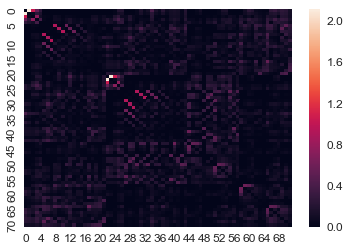

In [13]:
sns.heatmap(np.abs(f_nn_gwh[0] - f_test[0]))

In [14]:
p_nn_gwh = density_from_fock_batch(f_nn_gwh)

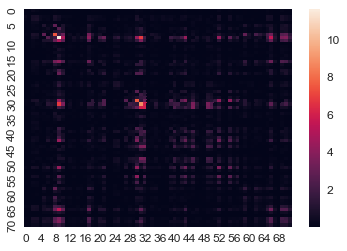

In [15]:
sns.heatmap(np.abs(p_nn_gwh[0] - p_test[0]))

In [16]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    p_nn_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-03 10:30:58: Iteration calculation: 0
[ ] 2019-01-03 10:30:59: Iteration calculation: 1
[ ] 2019-01-03 10:31:02: Iteration calculation: 2
[ ] 2019-01-03 10:31:03: Iteration calculation: 3
[ ] 2019-01-03 10:31:05: Iteration calculation: 4
[ ] 2019-01-03 10:31:06: Iteration calculation: 5
[ ] 2019-01-03 10:31:08: Iteration calculation: 6
[ ] 2019-01-03 10:31:09: Iteration calculation: 7
[ ] 2019-01-03 10:31:10: Iteration calculation: 8
[ ] 2019-01-03 10:31:11: Iteration calculation: 9
[ ] 2019-01-03 10:31:12: Iteration calculation: 10
[ ] 2019-01-03 10:31:14: Iteration calculation: 11
[ ] 2019-01-03 10:31:15: Iteration calculation: 12
[ ] 2019-01-03 10:31:15: Iteration calculation: 13
[ ] 2019-01-03 10:31:16: Iteration calculation: 14
[ ] 2019-01-03 10:31:17: Iteration calculation: 15
[ ] 2019-01-03 10:31:17: Iteration calculation: 16
[ ] 2019-01-03 10:31:19: Iteration calculation: 17
[ ] 2019-01-03 10:31:20: Iteration calculation: 18
[ ] 2019-01-03 10:31:21: Iteration calcul

[ ] 2019-01-03 10:34:32: Iteration calculation: 160
[ ] 2019-01-03 10:34:33: Iteration calculation: 161
[ ] 2019-01-03 10:34:34: Iteration calculation: 162
[ ] 2019-01-03 10:34:36: Iteration calculation: 163
[ ] 2019-01-03 10:34:36: Iteration calculation: 164
[ ] 2019-01-03 10:34:38: Iteration calculation: 165
[ ] 2019-01-03 10:34:38: Iteration calculation: 166
[ ] 2019-01-03 10:34:40: Iteration calculation: 167
[ ] 2019-01-03 10:34:40: Iteration calculation: 168
[ ] 2019-01-03 10:34:41: Iteration calculation: 169
[ ] 2019-01-03 10:34:42: Iteration calculation: 170
[ ] 2019-01-03 10:34:43: Iteration calculation: 171
[ ] 2019-01-03 10:34:43: Iteration calculation: 172
[ ] 2019-01-03 10:34:44: Iteration calculation: 173
[ ] 2019-01-03 10:34:45: Iteration calculation: 174
[ ] 2019-01-03 10:34:46: Iteration calculation: 175
[ ] 2019-01-03 10:34:48: Iteration calculation: 176
[ ] 2019-01-03 10:34:48: Iteration calculation: 177
[ ] 2019-01-03 10:34:50: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 10:37:42: Iteration calculation: 318
[ ] 2019-01-03 10:37:44: Iteration calculation: 319
[ ] 2019-01-03 10:37:46: Iteration calculation: 320
[ ] 2019-01-03 10:37:48: Iteration calculation: 321
[ ] 2019-01-03 10:37:49: Iteration calculation: 322
[ ] 2019-01-03 10:37:50: Iteration calculation: 323
[ ] 2019-01-03 10:37:51: Iteration calculation: 324
[ ] 2019-01-03 10:37:51: Iteration calculation: 325
[ ] 2019-01-03 10:37:53: Iteration calculation: 326
[ ] 2019-01-03 10:37:55: Iteration calculation: 327
[ ] 2019-01-03 10:37:57: Iteration calculation: 328
[ ] 2019-01-03 10:37:57: Iteration calculation: 329
[ ] 2019-01-03 10:37:59: Iteration calculation: 330
[ ] 2019-01-03 10:37:59: Iteration calculation: 331
[ ] 2019-01-03 10:38:00: Iteration calculation: 332
[ ] 2019-01-03 10:38:01: Iteration calculation: 333
[ ] 2019-01-03 10:38:02: Iteration calculation: 334
[ ] 2019-01-03 10:38:03: Iteration calculation: 335
[ ] 2019-01-03 10:38:05: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 10:40:49: Iteration calculation: 476
[ ] 2019-01-03 10:40:50: Iteration calculation: 477
[ ] 2019-01-03 10:40:51: Iteration calculation: 478
[ ] 2019-01-03 10:40:52: Iteration calculation: 479
[ ] 2019-01-03 10:40:53: Iteration calculation: 480
[ ] 2019-01-03 10:40:55: Iteration calculation: 481
[ ] 2019-01-03 10:40:57: Iteration calculation: 482
[ ] 2019-01-03 10:40:58: Iteration calculation: 483
[ ] 2019-01-03 10:41:00: Iteration calculation: 484
[ ] 2019-01-03 10:41:01: Iteration calculation: 485
[ ] 2019-01-03 10:41:01: Iteration calculation: 486
[ ] 2019-01-03 10:41:03: Iteration calculation: 487
[ ] 2019-01-03 10:41:04: Iteration calculation: 488
[ ] 2019-01-03 10:41:04: Iteration calculation: 489
[ ] 2019-01-03 10:41:05: Iteration calculation: 490
[ ] 2019-01-03 10:41:07: Iteration calculation: 491
[ ] 2019-01-03 10:41:09: Iteration calculation: 492
[ ] 2019-01-03 10:41:10: Iteration calculation: 493
[ ] 2019-01-03 10:41:12: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 10:44:08: Iteration calculation: 634
[ ] 2019-01-03 10:44:11: Iteration calculation: 635
[ ] 2019-01-03 10:44:13: Iteration calculation: 636
[ ] 2019-01-03 10:44:15: Iteration calculation: 637
[ ] 2019-01-03 10:44:16: Iteration calculation: 638
[ ] 2019-01-03 10:44:18: Iteration calculation: 639
[ ] 2019-01-03 10:44:19: Iteration calculation: 640
[ ] 2019-01-03 10:44:20: Iteration calculation: 641
[ ] 2019-01-03 10:44:21: Iteration calculation: 642
[ ] 2019-01-03 10:44:22: Iteration calculation: 643
[ ] 2019-01-03 10:44:23: Iteration calculation: 644
[ ] 2019-01-03 10:44:25: Iteration calculation: 645
[ ] 2019-01-03 10:44:26: Iteration calculation: 646
[ ] 2019-01-03 10:44:26: Iteration calculation: 647
[ ] 2019-01-03 10:44:28: Iteration calculation: 648
[ ] 2019-01-03 10:44:30: Iteration calculation: 649
[ ] 2019-01-03 10:44:32: Iteration calculation: 650
[ ] 2019-01-03 10:44:32: Iteration calculation: 651
[ ] 2019-01-03 10:44:33: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 10:47:27: Iteration calculation: 792
[ ] 2019-01-03 10:47:29: Iteration calculation: 793
[ ] 2019-01-03 10:47:29: Iteration calculation: 794
[ ] 2019-01-03 10:47:30: Iteration calculation: 795
[ ] 2019-01-03 10:47:32: Iteration calculation: 796
[ ] 2019-01-03 10:47:33: Iteration calculation: 797
[ ] 2019-01-03 10:47:36: Iteration calculation: 798
[ ] 2019-01-03 10:47:37: Iteration calculation: 799
[ ] 2019-01-03 10:47:39: Iteration calculation: 800
[ ] 2019-01-03 10:47:42: Iteration calculation: 801
[ ] 2019-01-03 10:47:43: Iteration calculation: 802
[ ] 2019-01-03 10:47:44: Iteration calculation: 803
[ ] 2019-01-03 10:47:46: Iteration calculation: 804
[ ] 2019-01-03 10:47:47: Iteration calculation: 805
[ ] 2019-01-03 10:47:49: Iteration calculation: 806
[ ] 2019-01-03 10:47:49: Iteration calculation: 807
[ ] 2019-01-03 10:47:50: Iteration calculation: 808
[ ] 2019-01-03 10:47:51: Iteration calculation: 809
[ ] 2019-01-03 10:47:52: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 10:50:42: Iteration calculation: 950
[ ] 2019-01-03 10:50:45: Iteration calculation: 951
[ ] 2019-01-03 10:50:46: Iteration calculation: 952
[ ] 2019-01-03 10:50:47: Iteration calculation: 953
[ ] 2019-01-03 10:50:49: Iteration calculation: 954
[ ] 2019-01-03 10:50:50: Iteration calculation: 955
[ ] 2019-01-03 10:50:52: Iteration calculation: 956
[ ] 2019-01-03 10:50:52: Iteration calculation: 957
[ ] 2019-01-03 10:50:53: Iteration calculation: 958
[ ] 2019-01-03 10:50:54: Iteration calculation: 959
[ ] 2019-01-03 10:50:55: Iteration calculation: 960
[ ] 2019-01-03 10:50:56: Iteration calculation: 961
[ ] 2019-01-03 10:50:57: Iteration calculation: 962
[ ] 2019-01-03 10:50:58: Iteration calculation: 963
[ ] 2019-01-03 10:51:00: Iteration calculation: 964
[ ] 2019-01-03 10:51:01: Iteration calculation: 965
[ ] 2019-01-03 10:51:03: Iteration calculation: 966
[ ] 2019-01-03 10:51:05: Iteration calculation: 967
[ ] 2019-01-03 10:51:06: Iteration calculation: 968
[ ] 2019-01-

In [39]:
432/len(p_test)

0.43156843156843155

### Damping 

In [18]:
from SCFInitialGuess.utilities.analysis import statistics

In [19]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-03 10:51:46: Iteration calculation: 0
[ ] 2019-01-03 10:51:46: Iteration calculation: 1
[ ] 2019-01-03 10:51:48: Iteration calculation: 2
[ ] 2019-01-03 10:51:50: Iteration calculation: 3
[ ] 2019-01-03 10:51:52: Iteration calculation: 4
[ ] 2019-01-03 10:51:52: Iteration calculation: 5
[ ] 2019-01-03 10:51:55: Iteration calculation: 6
[ ] 2019-01-03 10:51:55: Iteration calculation: 7
[ ] 2019-01-03 10:51:57: Iteration calculation: 8
[ ] 2019-01-03 10:51:58: Iteration calculation: 9
[ ] 2019-01-03 10:51:59: Iteration calculation: 10
[ ] 2019-01-03 10:52:01: Iteration calculation: 11
[ ] 2019-01-03 10:52:01: Iteration calculation: 12
[ ] 2019-01-03 10:52:02: Iteration calculation: 13
[ ] 2019-01-03 10:52:03: Iteration calculation: 14
[ ] 2019-01-03 10:52:05: Iteration calculation: 15
[ ] 2019-01-03 10:52:07: Iteration calculation: 16
[ ] 2019-01-03 10:52:08: Iteration calculation: 17
[ ] 2019-01-03 10:52:10: Iteration calculation: 18
[ ] 2019-01-03 10:52:12: Iteration calcul

[ ] 2019-01-03 10:55:14: Iteration calculation: 160
[ ] 2019-01-03 10:55:15: Iteration calculation: 161
[ ] 2019-01-03 10:55:15: Iteration calculation: 162
[ ] 2019-01-03 10:55:17: Iteration calculation: 163
[ ] 2019-01-03 10:55:18: Iteration calculation: 164
[ ] 2019-01-03 10:55:19: Iteration calculation: 165
[ ] 2019-01-03 10:55:20: Iteration calculation: 166
[ ] 2019-01-03 10:55:22: Iteration calculation: 167
[ ] 2019-01-03 10:55:23: Iteration calculation: 168
[ ] 2019-01-03 10:55:23: Iteration calculation: 169
[ ] 2019-01-03 10:55:24: Iteration calculation: 170
[ ] 2019-01-03 10:55:25: Iteration calculation: 171
[ ] 2019-01-03 10:55:26: Iteration calculation: 172
[ ] 2019-01-03 10:55:27: Iteration calculation: 173
[ ] 2019-01-03 10:55:28: Iteration calculation: 174
[ ] 2019-01-03 10:55:30: Iteration calculation: 175
[ ] 2019-01-03 10:55:32: Iteration calculation: 176
[ ] 2019-01-03 10:55:32: Iteration calculation: 177
[ ] 2019-01-03 10:55:34: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 10:58:30: Iteration calculation: 318
[ ] 2019-01-03 10:58:32: Iteration calculation: 319
[ ] 2019-01-03 10:58:33: Iteration calculation: 320
[ ] 2019-01-03 10:58:35: Iteration calculation: 321
[ ] 2019-01-03 10:58:37: Iteration calculation: 322
[ ] 2019-01-03 10:58:37: Iteration calculation: 323
[ ] 2019-01-03 10:58:40: Iteration calculation: 324
[ ] 2019-01-03 10:58:40: Iteration calculation: 325
[ ] 2019-01-03 10:58:42: Iteration calculation: 326
[ ] 2019-01-03 10:58:43: Iteration calculation: 327
[ ] 2019-01-03 10:58:45: Iteration calculation: 328
[ ] 2019-01-03 10:58:46: Iteration calculation: 329
[ ] 2019-01-03 10:58:48: Iteration calculation: 330
[ ] 2019-01-03 10:58:48: Iteration calculation: 331
[ ] 2019-01-03 10:58:49: Iteration calculation: 332
[ ] 2019-01-03 10:58:51: Iteration calculation: 333
[ ] 2019-01-03 10:58:53: Iteration calculation: 334
[ ] 2019-01-03 10:58:53: Iteration calculation: 335
[ ] 2019-01-03 10:58:55: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 11:01:46: Iteration calculation: 476
[ ] 2019-01-03 11:01:47: Iteration calculation: 477
[ ] 2019-01-03 11:01:48: Iteration calculation: 478
[ ] 2019-01-03 11:01:49: Iteration calculation: 479
[ ] 2019-01-03 11:01:49: Iteration calculation: 480
[ ] 2019-01-03 11:01:51: Iteration calculation: 481
[ ] 2019-01-03 11:01:53: Iteration calculation: 482
[ ] 2019-01-03 11:01:54: Iteration calculation: 483
[ ] 2019-01-03 11:01:55: Iteration calculation: 484
[ ] 2019-01-03 11:01:56: Iteration calculation: 485
[ ] 2019-01-03 11:01:57: Iteration calculation: 486
[ ] 2019-01-03 11:01:58: Iteration calculation: 487
[ ] 2019-01-03 11:01:59: Iteration calculation: 488
[ ] 2019-01-03 11:02:00: Iteration calculation: 489
[ ] 2019-01-03 11:02:01: Iteration calculation: 490
[ ] 2019-01-03 11:02:03: Iteration calculation: 491
[ ] 2019-01-03 11:02:04: Iteration calculation: 492
[ ] 2019-01-03 11:02:04: Iteration calculation: 493
[ ] 2019-01-03 11:02:07: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 11:05:15: Iteration calculation: 634
[ ] 2019-01-03 11:05:17: Iteration calculation: 635
[ ] 2019-01-03 11:05:18: Iteration calculation: 636
[ ] 2019-01-03 11:05:19: Iteration calculation: 637
[ ] 2019-01-03 11:05:19: Iteration calculation: 638
[ ] 2019-01-03 11:05:21: Iteration calculation: 639
[ ] 2019-01-03 11:05:23: Iteration calculation: 640
[ ] 2019-01-03 11:05:25: Iteration calculation: 641
[ ] 2019-01-03 11:05:25: Iteration calculation: 642
[ ] 2019-01-03 11:05:26: Iteration calculation: 643
[ ] 2019-01-03 11:05:27: Iteration calculation: 644
[ ] 2019-01-03 11:05:29: Iteration calculation: 645
[ ] 2019-01-03 11:05:30: Iteration calculation: 646
[ ] 2019-01-03 11:05:30: Iteration calculation: 647
[ ] 2019-01-03 11:05:32: Iteration calculation: 648
[ ] 2019-01-03 11:05:34: Iteration calculation: 649
[ ] 2019-01-03 11:05:35: Iteration calculation: 650
[ ] 2019-01-03 11:05:35: Iteration calculation: 651
[ ] 2019-01-03 11:05:37: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 11:08:23: Iteration calculation: 792
[ ] 2019-01-03 11:08:23: Iteration calculation: 793
[ ] 2019-01-03 11:08:24: Iteration calculation: 794
[ ] 2019-01-03 11:08:24: Iteration calculation: 795
[ ] 2019-01-03 11:08:26: Iteration calculation: 796
[ ] 2019-01-03 11:08:27: Iteration calculation: 797
[ ] 2019-01-03 11:08:29: Iteration calculation: 798
[ ] 2019-01-03 11:08:29: Iteration calculation: 799
[ ] 2019-01-03 11:08:31: Iteration calculation: 800
[ ] 2019-01-03 11:08:33: Iteration calculation: 801
[ ] 2019-01-03 11:08:34: Iteration calculation: 802
[ ] 2019-01-03 11:08:36: Iteration calculation: 803
[ ] 2019-01-03 11:08:38: Iteration calculation: 804
[ ] 2019-01-03 11:08:40: Iteration calculation: 805
[ ] 2019-01-03 11:08:40: Iteration calculation: 806
[ ] 2019-01-03 11:08:41: Iteration calculation: 807
[ ] 2019-01-03 11:08:41: Iteration calculation: 808
[ ] 2019-01-03 11:08:42: Iteration calculation: 809
[ ] 2019-01-03 11:08:43: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 11:11:51: Iteration calculation: 950
[ ] 2019-01-03 11:11:53: Iteration calculation: 951
[ ] 2019-01-03 11:11:54: Iteration calculation: 952
[ ] 2019-01-03 11:11:54: Iteration calculation: 953
[ ] 2019-01-03 11:11:56: Iteration calculation: 954
[ ] 2019-01-03 11:11:56: Iteration calculation: 955
[ ] 2019-01-03 11:11:58: Iteration calculation: 956
[ ] 2019-01-03 11:11:59: Iteration calculation: 957
[ ] 2019-01-03 11:11:59: Iteration calculation: 958
[ ] 2019-01-03 11:12:01: Iteration calculation: 959
[ ] 2019-01-03 11:12:02: Iteration calculation: 960
[ ] 2019-01-03 11:12:04: Iteration calculation: 961
[ ] 2019-01-03 11:12:04: Iteration calculation: 962
[ ] 2019-01-03 11:12:06: Iteration calculation: 963
[ ] 2019-01-03 11:12:08: Iteration calculation: 964
[ ] 2019-01-03 11:12:10: Iteration calculation: 965
[ ] 2019-01-03 11:12:11: Iteration calculation: 966
[ ] 2019-01-03 11:12:13: Iteration calculation: 967
[ ] 2019-01-03 11:12:13: Iteration calculation: 968
[ ] 2019-01-

### DIIS 

In [20]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-03 11:12:49: Iteration calculation: 0
[ ] 2019-01-03 11:12:50: Iteration calculation: 1
[ ] 2019-01-03 11:12:50: Iteration calculation: 2
[ ] 2019-01-03 11:12:51: Iteration calculation: 3
[ ] 2019-01-03 11:12:51: Iteration calculation: 4
[ ] 2019-01-03 11:12:51: Iteration calculation: 5
[ ] 2019-01-03 11:12:52: Iteration calculation: 6
[ ] 2019-01-03 11:12:52: Iteration calculation: 7
[ ] 2019-01-03 11:12:53: Iteration calculation: 8
[ ] 2019-01-03 11:12:53: Iteration calculation: 9
[ ] 2019-01-03 11:12:54: Iteration calculation: 10
[ ] 2019-01-03 11:12:54: Iteration calculation: 11
[ ] 2019-01-03 11:12:55: Iteration calculation: 12
[ ] 2019-01-03 11:12:55: Iteration calculation: 13
[ ] 2019-01-03 11:12:55: Iteration calculation: 14
[ ] 2019-01-03 11:12:56: Iteration calculation: 15
[ ] 2019-01-03 11:12:56: Iteration calculation: 16
[ ] 2019-01-03 11:12:57: Iteration calculation: 17
[ ] 2019-01-03 11:12:57: Iteration calculation: 18
[ ] 2019-01-03 11:12:58: Iteration calcul

[ ] 2019-01-03 11:14:08: Iteration calculation: 160
[ ] 2019-01-03 11:14:08: Iteration calculation: 161
[ ] 2019-01-03 11:14:09: Iteration calculation: 162
[ ] 2019-01-03 11:14:09: Iteration calculation: 163
[ ] 2019-01-03 11:14:10: Iteration calculation: 164
[ ] 2019-01-03 11:14:10: Iteration calculation: 165
[ ] 2019-01-03 11:14:11: Iteration calculation: 166
[ ] 2019-01-03 11:14:11: Iteration calculation: 167
[ ] 2019-01-03 11:14:12: Iteration calculation: 168
[ ] 2019-01-03 11:14:12: Iteration calculation: 169
[ ] 2019-01-03 11:14:13: Iteration calculation: 170
[ ] 2019-01-03 11:14:13: Iteration calculation: 171
[ ] 2019-01-03 11:14:14: Iteration calculation: 172
[ ] 2019-01-03 11:14:14: Iteration calculation: 173
[ ] 2019-01-03 11:14:14: Iteration calculation: 174
[ ] 2019-01-03 11:14:15: Iteration calculation: 175
[ ] 2019-01-03 11:14:15: Iteration calculation: 176
[ ] 2019-01-03 11:14:16: Iteration calculation: 177
[ ] 2019-01-03 11:14:16: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 11:15:22: Iteration calculation: 318
[ ] 2019-01-03 11:15:23: Iteration calculation: 319
[ ] 2019-01-03 11:15:23: Iteration calculation: 320
[ ] 2019-01-03 11:15:24: Iteration calculation: 321
[ ] 2019-01-03 11:15:24: Iteration calculation: 322
[ ] 2019-01-03 11:15:25: Iteration calculation: 323
[ ] 2019-01-03 11:15:25: Iteration calculation: 324
[ ] 2019-01-03 11:15:26: Iteration calculation: 325
[ ] 2019-01-03 11:15:26: Iteration calculation: 326
[ ] 2019-01-03 11:15:27: Iteration calculation: 327
[ ] 2019-01-03 11:15:27: Iteration calculation: 328
[ ] 2019-01-03 11:15:28: Iteration calculation: 329
[ ] 2019-01-03 11:15:28: Iteration calculation: 330
[ ] 2019-01-03 11:15:29: Iteration calculation: 331
[ ] 2019-01-03 11:15:29: Iteration calculation: 332
[ ] 2019-01-03 11:15:30: Iteration calculation: 333
[ ] 2019-01-03 11:15:30: Iteration calculation: 334
[ ] 2019-01-03 11:15:31: Iteration calculation: 335
[ ] 2019-01-03 11:15:32: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 11:16:37: Iteration calculation: 476
[ ] 2019-01-03 11:16:38: Iteration calculation: 477
[ ] 2019-01-03 11:16:38: Iteration calculation: 478
[ ] 2019-01-03 11:16:39: Iteration calculation: 479
[ ] 2019-01-03 11:16:39: Iteration calculation: 480
[ ] 2019-01-03 11:16:39: Iteration calculation: 481
[ ] 2019-01-03 11:16:40: Iteration calculation: 482
[ ] 2019-01-03 11:16:40: Iteration calculation: 483
[ ] 2019-01-03 11:16:41: Iteration calculation: 484
[ ] 2019-01-03 11:16:42: Iteration calculation: 485
[ ] 2019-01-03 11:16:42: Iteration calculation: 486
[ ] 2019-01-03 11:16:43: Iteration calculation: 487
[ ] 2019-01-03 11:16:43: Iteration calculation: 488
[ ] 2019-01-03 11:16:44: Iteration calculation: 489
[ ] 2019-01-03 11:16:44: Iteration calculation: 490
[ ] 2019-01-03 11:16:45: Iteration calculation: 491
[ ] 2019-01-03 11:16:45: Iteration calculation: 492
[ ] 2019-01-03 11:16:45: Iteration calculation: 493
[ ] 2019-01-03 11:16:46: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 11:17:51: Iteration calculation: 634
[ ] 2019-01-03 11:17:51: Iteration calculation: 635
[ ] 2019-01-03 11:17:52: Iteration calculation: 636
[ ] 2019-01-03 11:17:52: Iteration calculation: 637
[ ] 2019-01-03 11:17:53: Iteration calculation: 638
[ ] 2019-01-03 11:17:53: Iteration calculation: 639
[ ] 2019-01-03 11:17:54: Iteration calculation: 640
[ ] 2019-01-03 11:17:54: Iteration calculation: 641
[ ] 2019-01-03 11:17:55: Iteration calculation: 642
[ ] 2019-01-03 11:17:55: Iteration calculation: 643
[ ] 2019-01-03 11:17:56: Iteration calculation: 644
[ ] 2019-01-03 11:17:56: Iteration calculation: 645
[ ] 2019-01-03 11:17:57: Iteration calculation: 646
[ ] 2019-01-03 11:17:57: Iteration calculation: 647
[ ] 2019-01-03 11:17:58: Iteration calculation: 648
[ ] 2019-01-03 11:17:58: Iteration calculation: 649
[ ] 2019-01-03 11:17:59: Iteration calculation: 650
[ ] 2019-01-03 11:17:59: Iteration calculation: 651
[ ] 2019-01-03 11:18:00: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 11:19:04: Iteration calculation: 792
[ ] 2019-01-03 11:19:04: Iteration calculation: 793
[ ] 2019-01-03 11:19:05: Iteration calculation: 794
[ ] 2019-01-03 11:19:05: Iteration calculation: 795
[ ] 2019-01-03 11:19:06: Iteration calculation: 796
[ ] 2019-01-03 11:19:06: Iteration calculation: 797
[ ] 2019-01-03 11:19:07: Iteration calculation: 798
[ ] 2019-01-03 11:19:07: Iteration calculation: 799
[ ] 2019-01-03 11:19:08: Iteration calculation: 800
[ ] 2019-01-03 11:19:08: Iteration calculation: 801
[ ] 2019-01-03 11:19:09: Iteration calculation: 802
[ ] 2019-01-03 11:19:09: Iteration calculation: 803
[ ] 2019-01-03 11:19:10: Iteration calculation: 804
[ ] 2019-01-03 11:19:10: Iteration calculation: 805
[ ] 2019-01-03 11:19:10: Iteration calculation: 806
[ ] 2019-01-03 11:19:11: Iteration calculation: 807
[ ] 2019-01-03 11:19:11: Iteration calculation: 808
[ ] 2019-01-03 11:19:12: Iteration calculation: 809
[ ] 2019-01-03 11:19:12: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 11:20:16: Iteration calculation: 950
[ ] 2019-01-03 11:20:16: Iteration calculation: 951
[ ] 2019-01-03 11:20:17: Iteration calculation: 952
[ ] 2019-01-03 11:20:17: Iteration calculation: 953
[ ] 2019-01-03 11:20:18: Iteration calculation: 954
[ ] 2019-01-03 11:20:18: Iteration calculation: 955
[ ] 2019-01-03 11:20:19: Iteration calculation: 956
[ ] 2019-01-03 11:20:19: Iteration calculation: 957
[ ] 2019-01-03 11:20:20: Iteration calculation: 958
[ ] 2019-01-03 11:20:20: Iteration calculation: 959
[ ] 2019-01-03 11:20:21: Iteration calculation: 960
[ ] 2019-01-03 11:20:21: Iteration calculation: 961
[ ] 2019-01-03 11:20:22: Iteration calculation: 962
[ ] 2019-01-03 11:20:22: Iteration calculation: 963
[ ] 2019-01-03 11:20:23: Iteration calculation: 964
[ ] 2019-01-03 11:20:23: Iteration calculation: 965
[ ] 2019-01-03 11:20:24: Iteration calculation: 966
[ ] 2019-01-03 11:20:24: Iteration calculation: 967
[ ] 2019-01-03 11:20:25: Iteration calculation: 968
[ ] 2019-01-

# EGWH + 

In [21]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

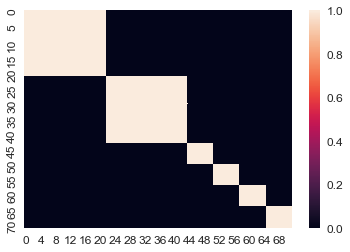

In [22]:
sns.heatmap(mask.astype(int))

In [23]:
def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(f_batch):
    f_embedded = []
    for (f_guess, f_conv) in zip(f_batch, f_test):
        f_embedded.append(embedd(f_guess, f_conv))
    return np.array(f_embedded)

In [24]:
np.mean(np.abs(embedd_batch(f_test).flatten() - f_test.flatten()))

0.0

In [25]:
f_nn_gwh_plus = embedd_batch(f_nn_gwh)

In [26]:
p_nn_gwh_plus = density_from_fock_batch(f_nn_gwh_plus)

In [27]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    p_nn_gwh_plus,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-03 11:29:17: Iteration calculation: 0
[ ] 2019-01-03 11:29:18: Iteration calculation: 1
[ ] 2019-01-03 11:29:20: Iteration calculation: 2
[ ] 2019-01-03 11:29:22: Iteration calculation: 3
[ ] 2019-01-03 11:29:23: Iteration calculation: 4
[ ] 2019-01-03 11:29:23: Iteration calculation: 5
[ ] 2019-01-03 11:29:24: Iteration calculation: 6
[ ] 2019-01-03 11:29:24: Iteration calculation: 7
[ ] 2019-01-03 11:29:25: Iteration calculation: 8
[ ] 2019-01-03 11:29:27: Iteration calculation: 9
[ ] 2019-01-03 11:29:28: Iteration calculation: 10
[ ] 2019-01-03 11:29:30: Iteration calculation: 11
[ ] 2019-01-03 11:29:31: Iteration calculation: 12
[ ] 2019-01-03 11:29:32: Iteration calculation: 13
[ ] 2019-01-03 11:29:32: Iteration calculation: 14
[ ] 2019-01-03 11:29:34: Iteration calculation: 15
[ ] 2019-01-03 11:29:35: Iteration calculation: 16
[ ] 2019-01-03 11:29:36: Iteration calculation: 17
[ ] 2019-01-03 11:29:37: Iteration calculation: 18
[ ] 2019-01-03 11:29:38: Iteration calcul

[ ] 2019-01-03 11:32:45: Iteration calculation: 160
[ ] 2019-01-03 11:32:46: Iteration calculation: 161
[ ] 2019-01-03 11:32:47: Iteration calculation: 162
[ ] 2019-01-03 11:32:49: Iteration calculation: 163
[ ] 2019-01-03 11:32:50: Iteration calculation: 164
[ ] 2019-01-03 11:32:51: Iteration calculation: 165
[ ] 2019-01-03 11:32:52: Iteration calculation: 166
[ ] 2019-01-03 11:32:54: Iteration calculation: 167
[ ] 2019-01-03 11:32:55: Iteration calculation: 168
[ ] 2019-01-03 11:32:55: Iteration calculation: 169
[ ] 2019-01-03 11:32:57: Iteration calculation: 170
[ ] 2019-01-03 11:32:58: Iteration calculation: 171
[ ] 2019-01-03 11:32:58: Iteration calculation: 172
[ ] 2019-01-03 11:32:59: Iteration calculation: 173
[ ] 2019-01-03 11:33:01: Iteration calculation: 174
[ ] 2019-01-03 11:33:02: Iteration calculation: 175
[ ] 2019-01-03 11:33:04: Iteration calculation: 176
[ ] 2019-01-03 11:33:05: Iteration calculation: 177
[ ] 2019-01-03 11:33:07: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 11:36:05: Iteration calculation: 318
[ ] 2019-01-03 11:36:07: Iteration calculation: 319
[ ] 2019-01-03 11:36:09: Iteration calculation: 320
[ ] 2019-01-03 11:36:10: Iteration calculation: 321
[ ] 2019-01-03 11:36:12: Iteration calculation: 322
[ ] 2019-01-03 11:36:13: Iteration calculation: 323
[ ] 2019-01-03 11:36:13: Iteration calculation: 324
[ ] 2019-01-03 11:36:14: Iteration calculation: 325
[ ] 2019-01-03 11:36:16: Iteration calculation: 326
[ ] 2019-01-03 11:36:16: Iteration calculation: 327
[ ] 2019-01-03 11:36:18: Iteration calculation: 328
[ ] 2019-01-03 11:36:19: Iteration calculation: 329
[ ] 2019-01-03 11:36:20: Iteration calculation: 330
[ ] 2019-01-03 11:36:21: Iteration calculation: 331
[ ] 2019-01-03 11:36:23: Iteration calculation: 332
[ ] 2019-01-03 11:36:25: Iteration calculation: 333
[ ] 2019-01-03 11:36:27: Iteration calculation: 334
[ ] 2019-01-03 11:36:28: Iteration calculation: 335
[ ] 2019-01-03 11:36:29: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 11:39:38: Iteration calculation: 476
[ ] 2019-01-03 11:39:39: Iteration calculation: 477
[ ] 2019-01-03 11:39:41: Iteration calculation: 478
[ ] 2019-01-03 11:39:41: Iteration calculation: 479
[ ] 2019-01-03 11:39:42: Iteration calculation: 480
[ ] 2019-01-03 11:39:44: Iteration calculation: 481
[ ] 2019-01-03 11:39:46: Iteration calculation: 482
[ ] 2019-01-03 11:39:46: Iteration calculation: 483
[ ] 2019-01-03 11:39:48: Iteration calculation: 484
[ ] 2019-01-03 11:39:49: Iteration calculation: 485
[ ] 2019-01-03 11:39:49: Iteration calculation: 486
[ ] 2019-01-03 11:39:51: Iteration calculation: 487
[ ] 2019-01-03 11:39:52: Iteration calculation: 488
[ ] 2019-01-03 11:39:52: Iteration calculation: 489
[ ] 2019-01-03 11:39:53: Iteration calculation: 490
[ ] 2019-01-03 11:39:55: Iteration calculation: 491
[ ] 2019-01-03 11:39:57: Iteration calculation: 492
[ ] 2019-01-03 11:39:58: Iteration calculation: 493
[ ] 2019-01-03 11:40:00: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 11:43:09: Iteration calculation: 634
[ ] 2019-01-03 11:43:10: Iteration calculation: 635
[ ] 2019-01-03 11:43:12: Iteration calculation: 636
[ ] 2019-01-03 11:43:13: Iteration calculation: 637
[ ] 2019-01-03 11:43:14: Iteration calculation: 638
[ ] 2019-01-03 11:43:14: Iteration calculation: 639
[ ] 2019-01-03 11:43:16: Iteration calculation: 640
[ ] 2019-01-03 11:43:17: Iteration calculation: 641
[ ] 2019-01-03 11:43:17: Iteration calculation: 642
[ ] 2019-01-03 11:43:18: Iteration calculation: 643
[ ] 2019-01-03 11:43:20: Iteration calculation: 644
[ ] 2019-01-03 11:43:22: Iteration calculation: 645
[ ] 2019-01-03 11:43:23: Iteration calculation: 646
[ ] 2019-01-03 11:43:23: Iteration calculation: 647
[ ] 2019-01-03 11:43:25: Iteration calculation: 648
[ ] 2019-01-03 11:43:27: Iteration calculation: 649
[ ] 2019-01-03 11:43:28: Iteration calculation: 650
[ ] 2019-01-03 11:43:29: Iteration calculation: 651
[ ] 2019-01-03 11:43:31: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 11:46:26: Iteration calculation: 792
[ ] 2019-01-03 11:46:28: Iteration calculation: 793
[ ] 2019-01-03 11:46:28: Iteration calculation: 794
[ ] 2019-01-03 11:46:29: Iteration calculation: 795
[ ] 2019-01-03 11:46:30: Iteration calculation: 796
[ ] 2019-01-03 11:46:31: Iteration calculation: 797
[ ] 2019-01-03 11:46:32: Iteration calculation: 798
[ ] 2019-01-03 11:46:34: Iteration calculation: 799
[ ] 2019-01-03 11:46:34: Iteration calculation: 800
[ ] 2019-01-03 11:46:35: Iteration calculation: 801
[ ] 2019-01-03 11:46:37: Iteration calculation: 802
[ ] 2019-01-03 11:46:39: Iteration calculation: 803
[ ] 2019-01-03 11:46:41: Iteration calculation: 804
[ ] 2019-01-03 11:46:42: Iteration calculation: 805
[ ] 2019-01-03 11:46:44: Iteration calculation: 806
[ ] 2019-01-03 11:46:44: Iteration calculation: 807
[ ] 2019-01-03 11:46:45: Iteration calculation: 808
[ ] 2019-01-03 11:46:46: Iteration calculation: 809
[ ] 2019-01-03 11:46:46: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 11:49:48: Iteration calculation: 950
[ ] 2019-01-03 11:49:48: Iteration calculation: 951
[ ] 2019-01-03 11:49:50: Iteration calculation: 952
[ ] 2019-01-03 11:49:51: Iteration calculation: 953
[ ] 2019-01-03 11:49:52: Iteration calculation: 954
[ ] 2019-01-03 11:49:53: Iteration calculation: 955
[ ] 2019-01-03 11:49:55: Iteration calculation: 956
[ ] 2019-01-03 11:49:56: Iteration calculation: 957
[ ] 2019-01-03 11:49:57: Iteration calculation: 958
[ ] 2019-01-03 11:50:00: Iteration calculation: 959
[ ] 2019-01-03 11:50:00: Iteration calculation: 960
[ ] 2019-01-03 11:50:02: Iteration calculation: 961
[ ] 2019-01-03 11:50:03: Iteration calculation: 962
[ ] 2019-01-03 11:50:05: Iteration calculation: 963
[ ] 2019-01-03 11:50:07: Iteration calculation: 964
[ ] 2019-01-03 11:50:09: Iteration calculation: 965
[ ] 2019-01-03 11:50:09: Iteration calculation: 966
[ ] 2019-01-03 11:50:11: Iteration calculation: 967
[ ] 2019-01-03 11:50:12: Iteration calculation: 968
[ ] 2019-01-

In [36]:
426/len(p_test)

0.4255744255744256

### Damping 

In [29]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn_gwh_plus, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-03 11:50:50: Iteration calculation: 0
[ ] 2019-01-03 11:50:51: Iteration calculation: 1
[ ] 2019-01-03 11:50:52: Iteration calculation: 2
[ ] 2019-01-03 11:50:54: Iteration calculation: 3
[ ] 2019-01-03 11:50:55: Iteration calculation: 4
[ ] 2019-01-03 11:50:55: Iteration calculation: 5
[ ] 2019-01-03 11:50:56: Iteration calculation: 6
[ ] 2019-01-03 11:50:57: Iteration calculation: 7
[ ] 2019-01-03 11:50:57: Iteration calculation: 8
[ ] 2019-01-03 11:50:59: Iteration calculation: 9
[ ] 2019-01-03 11:50:59: Iteration calculation: 10
[ ] 2019-01-03 11:51:01: Iteration calculation: 11
[ ] 2019-01-03 11:51:02: Iteration calculation: 12
[ ] 2019-01-03 11:51:03: Iteration calculation: 13
[ ] 2019-01-03 11:51:04: Iteration calculation: 14
[ ] 2019-01-03 11:51:05: Iteration calculation: 15
[ ] 2019-01-03 11:51:06: Iteration calculation: 16
[ ] 2019-01-03 11:51:08: Iteration calculation: 17
[ ] 2019-01-03 11:51:08: Iteration calculation: 18
[ ] 2019-01-03 11:51:09: Iteration calcul

[ ] 2019-01-03 11:53:57: Iteration calculation: 160
[ ] 2019-01-03 11:53:58: Iteration calculation: 161
[ ] 2019-01-03 11:53:59: Iteration calculation: 162
[ ] 2019-01-03 11:54:02: Iteration calculation: 163
[ ] 2019-01-03 11:54:03: Iteration calculation: 164
[ ] 2019-01-03 11:54:03: Iteration calculation: 165
[ ] 2019-01-03 11:54:05: Iteration calculation: 166
[ ] 2019-01-03 11:54:07: Iteration calculation: 167
[ ] 2019-01-03 11:54:07: Iteration calculation: 168
[ ] 2019-01-03 11:54:08: Iteration calculation: 169
[ ] 2019-01-03 11:54:10: Iteration calculation: 170
[ ] 2019-01-03 11:54:11: Iteration calculation: 171
[ ] 2019-01-03 11:54:11: Iteration calculation: 172
[ ] 2019-01-03 11:54:12: Iteration calculation: 173
[ ] 2019-01-03 11:54:13: Iteration calculation: 174
[ ] 2019-01-03 11:54:14: Iteration calculation: 175
[ ] 2019-01-03 11:54:15: Iteration calculation: 176
[ ] 2019-01-03 11:54:15: Iteration calculation: 177
[ ] 2019-01-03 11:54:17: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 11:56:56: Iteration calculation: 318
[ ] 2019-01-03 11:56:58: Iteration calculation: 319
[ ] 2019-01-03 11:56:59: Iteration calculation: 320
[ ] 2019-01-03 11:57:01: Iteration calculation: 321
[ ] 2019-01-03 11:57:02: Iteration calculation: 322
[ ] 2019-01-03 11:57:03: Iteration calculation: 323
[ ] 2019-01-03 11:57:03: Iteration calculation: 324
[ ] 2019-01-03 11:57:04: Iteration calculation: 325
[ ] 2019-01-03 11:57:06: Iteration calculation: 326
[ ] 2019-01-03 11:57:08: Iteration calculation: 327
[ ] 2019-01-03 11:57:10: Iteration calculation: 328
[ ] 2019-01-03 11:57:10: Iteration calculation: 329
[ ] 2019-01-03 11:57:12: Iteration calculation: 330
[ ] 2019-01-03 11:57:13: Iteration calculation: 331
[ ] 2019-01-03 11:57:15: Iteration calculation: 332
[ ] 2019-01-03 11:57:15: Iteration calculation: 333
[ ] 2019-01-03 11:57:17: Iteration calculation: 334
[ ] 2019-01-03 11:57:19: Iteration calculation: 335
[ ] 2019-01-03 11:57:20: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 11:59:55: Iteration calculation: 476
[ ] 2019-01-03 11:59:56: Iteration calculation: 477
[ ] 2019-01-03 11:59:58: Iteration calculation: 478
[ ] 2019-01-03 11:59:58: Iteration calculation: 479
[ ] 2019-01-03 11:59:59: Iteration calculation: 480
[ ] 2019-01-03 12:00:01: Iteration calculation: 481
[ ] 2019-01-03 12:00:03: Iteration calculation: 482
[ ] 2019-01-03 12:00:03: Iteration calculation: 483
[ ] 2019-01-03 12:00:05: Iteration calculation: 484
[ ] 2019-01-03 12:00:06: Iteration calculation: 485
[ ] 2019-01-03 12:00:07: Iteration calculation: 486
[ ] 2019-01-03 12:00:08: Iteration calculation: 487
[ ] 2019-01-03 12:00:09: Iteration calculation: 488
[ ] 2019-01-03 12:00:10: Iteration calculation: 489
[ ] 2019-01-03 12:00:10: Iteration calculation: 490
[ ] 2019-01-03 12:00:11: Iteration calculation: 491
[ ] 2019-01-03 12:00:12: Iteration calculation: 492
[ ] 2019-01-03 12:00:12: Iteration calculation: 493
[ ] 2019-01-03 12:00:13: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 12:02:59: Iteration calculation: 634
[ ] 2019-01-03 12:03:00: Iteration calculation: 635
[ ] 2019-01-03 12:03:01: Iteration calculation: 636
[ ] 2019-01-03 12:03:02: Iteration calculation: 637
[ ] 2019-01-03 12:03:03: Iteration calculation: 638
[ ] 2019-01-03 12:03:04: Iteration calculation: 639
[ ] 2019-01-03 12:03:06: Iteration calculation: 640
[ ] 2019-01-03 12:03:07: Iteration calculation: 641
[ ] 2019-01-03 12:03:08: Iteration calculation: 642
[ ] 2019-01-03 12:03:08: Iteration calculation: 643
[ ] 2019-01-03 12:03:10: Iteration calculation: 644
[ ] 2019-01-03 12:03:11: Iteration calculation: 645
[ ] 2019-01-03 12:03:12: Iteration calculation: 646
[ ] 2019-01-03 12:03:13: Iteration calculation: 647
[ ] 2019-01-03 12:03:15: Iteration calculation: 648
[ ] 2019-01-03 12:03:17: Iteration calculation: 649
[ ] 2019-01-03 12:03:18: Iteration calculation: 650
[ ] 2019-01-03 12:03:18: Iteration calculation: 651
[ ] 2019-01-03 12:03:20: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 12:06:02: Iteration calculation: 792
[ ] 2019-01-03 12:06:03: Iteration calculation: 793
[ ] 2019-01-03 12:06:03: Iteration calculation: 794
[ ] 2019-01-03 12:06:04: Iteration calculation: 795
[ ] 2019-01-03 12:06:06: Iteration calculation: 796
[ ] 2019-01-03 12:06:07: Iteration calculation: 797
[ ] 2019-01-03 12:06:07: Iteration calculation: 798
[ ] 2019-01-03 12:06:09: Iteration calculation: 799
[ ] 2019-01-03 12:06:10: Iteration calculation: 800
[ ] 2019-01-03 12:06:10: Iteration calculation: 801
[ ] 2019-01-03 12:06:12: Iteration calculation: 802
[ ] 2019-01-03 12:06:14: Iteration calculation: 803
[ ] 2019-01-03 12:06:16: Iteration calculation: 804
[ ] 2019-01-03 12:06:17: Iteration calculation: 805
[ ] 2019-01-03 12:06:17: Iteration calculation: 806
[ ] 2019-01-03 12:06:18: Iteration calculation: 807
[ ] 2019-01-03 12:06:18: Iteration calculation: 808
[ ] 2019-01-03 12:06:19: Iteration calculation: 809
[ ] 2019-01-03 12:06:20: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 12:08:58: Iteration calculation: 950
[ ] 2019-01-03 12:08:59: Iteration calculation: 951
[ ] 2019-01-03 12:08:59: Iteration calculation: 952
[ ] 2019-01-03 12:09:00: Iteration calculation: 953
[ ] 2019-01-03 12:09:00: Iteration calculation: 954
[ ] 2019-01-03 12:09:01: Iteration calculation: 955
[ ] 2019-01-03 12:09:02: Iteration calculation: 956
[ ] 2019-01-03 12:09:03: Iteration calculation: 957
[ ] 2019-01-03 12:09:04: Iteration calculation: 958
[ ] 2019-01-03 12:09:06: Iteration calculation: 959
[ ] 2019-01-03 12:09:07: Iteration calculation: 960
[ ] 2019-01-03 12:09:08: Iteration calculation: 961
[ ] 2019-01-03 12:09:09: Iteration calculation: 962
[ ] 2019-01-03 12:09:11: Iteration calculation: 963
[ ] 2019-01-03 12:09:12: Iteration calculation: 964
[ ] 2019-01-03 12:09:13: Iteration calculation: 965
[ ] 2019-01-03 12:09:14: Iteration calculation: 966
[ ] 2019-01-03 12:09:16: Iteration calculation: 967
[ ] 2019-01-03 12:09:16: Iteration calculation: 968
[ ] 2019-01-

### DIIS 

In [30]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn_gwh_plus, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-03 12:09:51: Iteration calculation: 0
[ ] 2019-01-03 12:09:51: Iteration calculation: 1
[ ] 2019-01-03 12:09:52: Iteration calculation: 2
[ ] 2019-01-03 12:09:52: Iteration calculation: 3
[ ] 2019-01-03 12:09:53: Iteration calculation: 4
[ ] 2019-01-03 12:09:53: Iteration calculation: 5
[ ] 2019-01-03 12:09:54: Iteration calculation: 6
[ ] 2019-01-03 12:09:54: Iteration calculation: 7
[ ] 2019-01-03 12:09:54: Iteration calculation: 8
[ ] 2019-01-03 12:09:55: Iteration calculation: 9
[ ] 2019-01-03 12:09:55: Iteration calculation: 10
[ ] 2019-01-03 12:09:56: Iteration calculation: 11
[ ] 2019-01-03 12:09:56: Iteration calculation: 12
[ ] 2019-01-03 12:09:57: Iteration calculation: 13
[ ] 2019-01-03 12:09:57: Iteration calculation: 14
[ ] 2019-01-03 12:09:58: Iteration calculation: 15
[ ] 2019-01-03 12:09:58: Iteration calculation: 16
[ ] 2019-01-03 12:09:59: Iteration calculation: 17
[ ] 2019-01-03 12:09:59: Iteration calculation: 18
[ ] 2019-01-03 12:10:00: Iteration calcul

[ ] 2019-01-03 12:11:07: Iteration calculation: 160
[ ] 2019-01-03 12:11:08: Iteration calculation: 161
[ ] 2019-01-03 12:11:08: Iteration calculation: 162
[ ] 2019-01-03 12:11:09: Iteration calculation: 163
[ ] 2019-01-03 12:11:09: Iteration calculation: 164
[ ] 2019-01-03 12:11:10: Iteration calculation: 165
[ ] 2019-01-03 12:11:10: Iteration calculation: 166
[ ] 2019-01-03 12:11:11: Iteration calculation: 167
[ ] 2019-01-03 12:11:11: Iteration calculation: 168
[ ] 2019-01-03 12:11:12: Iteration calculation: 169
[ ] 2019-01-03 12:11:12: Iteration calculation: 170
[ ] 2019-01-03 12:11:13: Iteration calculation: 171
[ ] 2019-01-03 12:11:13: Iteration calculation: 172
[ ] 2019-01-03 12:11:13: Iteration calculation: 173
[ ] 2019-01-03 12:11:14: Iteration calculation: 174
[ ] 2019-01-03 12:11:14: Iteration calculation: 175
[ ] 2019-01-03 12:11:15: Iteration calculation: 176
[ ] 2019-01-03 12:11:15: Iteration calculation: 177
[ ] 2019-01-03 12:11:16: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 12:12:24: Iteration calculation: 318
[ ] 2019-01-03 12:12:24: Iteration calculation: 319
[ ] 2019-01-03 12:12:25: Iteration calculation: 320
[ ] 2019-01-03 12:12:25: Iteration calculation: 321
[ ] 2019-01-03 12:12:26: Iteration calculation: 322
[ ] 2019-01-03 12:12:26: Iteration calculation: 323
[ ] 2019-01-03 12:12:27: Iteration calculation: 324
[ ] 2019-01-03 12:12:28: Iteration calculation: 325
[ ] 2019-01-03 12:12:28: Iteration calculation: 326
[ ] 2019-01-03 12:12:29: Iteration calculation: 327
[ ] 2019-01-03 12:12:29: Iteration calculation: 328
[ ] 2019-01-03 12:12:29: Iteration calculation: 329
[ ] 2019-01-03 12:12:30: Iteration calculation: 330
[ ] 2019-01-03 12:12:30: Iteration calculation: 331
[ ] 2019-01-03 12:12:31: Iteration calculation: 332
[ ] 2019-01-03 12:12:31: Iteration calculation: 333
[ ] 2019-01-03 12:12:32: Iteration calculation: 334
[ ] 2019-01-03 12:12:32: Iteration calculation: 335
[ ] 2019-01-03 12:12:32: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 12:13:38: Iteration calculation: 476
[ ] 2019-01-03 12:13:39: Iteration calculation: 477
[ ] 2019-01-03 12:13:39: Iteration calculation: 478
[ ] 2019-01-03 12:13:40: Iteration calculation: 479
[ ] 2019-01-03 12:13:41: Iteration calculation: 480
[ ] 2019-01-03 12:13:42: Iteration calculation: 481
[ ] 2019-01-03 12:13:43: Iteration calculation: 482
[ ] 2019-01-03 12:13:45: Iteration calculation: 483
[ ] 2019-01-03 12:13:45: Iteration calculation: 484
[ ] 2019-01-03 12:13:46: Iteration calculation: 485
[ ] 2019-01-03 12:13:47: Iteration calculation: 486
[ ] 2019-01-03 12:13:47: Iteration calculation: 487
[ ] 2019-01-03 12:13:48: Iteration calculation: 488
[ ] 2019-01-03 12:13:49: Iteration calculation: 489
[ ] 2019-01-03 12:13:49: Iteration calculation: 490
[ ] 2019-01-03 12:13:50: Iteration calculation: 491
[ ] 2019-01-03 12:13:50: Iteration calculation: 492
[ ] 2019-01-03 12:13:51: Iteration calculation: 493
[ ] 2019-01-03 12:13:51: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 12:14:57: Iteration calculation: 634
[ ] 2019-01-03 12:14:57: Iteration calculation: 635
[ ] 2019-01-03 12:14:58: Iteration calculation: 636
[ ] 2019-01-03 12:14:58: Iteration calculation: 637
[ ] 2019-01-03 12:14:59: Iteration calculation: 638
[ ] 2019-01-03 12:14:59: Iteration calculation: 639
[ ] 2019-01-03 12:15:00: Iteration calculation: 640
[ ] 2019-01-03 12:15:00: Iteration calculation: 641
[ ] 2019-01-03 12:15:00: Iteration calculation: 642
[ ] 2019-01-03 12:15:01: Iteration calculation: 643
[ ] 2019-01-03 12:15:01: Iteration calculation: 644
[ ] 2019-01-03 12:15:02: Iteration calculation: 645
[ ] 2019-01-03 12:15:02: Iteration calculation: 646
[ ] 2019-01-03 12:15:03: Iteration calculation: 647
[ ] 2019-01-03 12:15:03: Iteration calculation: 648
[ ] 2019-01-03 12:15:04: Iteration calculation: 649
[ ] 2019-01-03 12:15:04: Iteration calculation: 650
[ ] 2019-01-03 12:15:05: Iteration calculation: 651
[ ] 2019-01-03 12:15:05: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 12:16:10: Iteration calculation: 792
[ ] 2019-01-03 12:16:10: Iteration calculation: 793
[ ] 2019-01-03 12:16:10: Iteration calculation: 794
[ ] 2019-01-03 12:16:11: Iteration calculation: 795
[ ] 2019-01-03 12:16:11: Iteration calculation: 796
[ ] 2019-01-03 12:16:12: Iteration calculation: 797
[ ] 2019-01-03 12:16:12: Iteration calculation: 798
[ ] 2019-01-03 12:16:12: Iteration calculation: 799
[ ] 2019-01-03 12:16:13: Iteration calculation: 800
[ ] 2019-01-03 12:16:13: Iteration calculation: 801
[ ] 2019-01-03 12:16:14: Iteration calculation: 802
[ ] 2019-01-03 12:16:14: Iteration calculation: 803
[ ] 2019-01-03 12:16:15: Iteration calculation: 804
[ ] 2019-01-03 12:16:16: Iteration calculation: 805
[ ] 2019-01-03 12:16:16: Iteration calculation: 806
[ ] 2019-01-03 12:16:17: Iteration calculation: 807
[ ] 2019-01-03 12:16:17: Iteration calculation: 808
[ ] 2019-01-03 12:16:17: Iteration calculation: 809
[ ] 2019-01-03 12:16:18: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 12:17:28: Iteration calculation: 950
[ ] 2019-01-03 12:17:28: Iteration calculation: 951
[ ] 2019-01-03 12:17:28: Iteration calculation: 952
[ ] 2019-01-03 12:17:29: Iteration calculation: 953
[ ] 2019-01-03 12:17:29: Iteration calculation: 954
[ ] 2019-01-03 12:17:30: Iteration calculation: 955
[ ] 2019-01-03 12:17:30: Iteration calculation: 956
[ ] 2019-01-03 12:17:31: Iteration calculation: 957
[ ] 2019-01-03 12:17:31: Iteration calculation: 958
[ ] 2019-01-03 12:17:32: Iteration calculation: 959
[ ] 2019-01-03 12:17:32: Iteration calculation: 960
[ ] 2019-01-03 12:17:33: Iteration calculation: 961
[ ] 2019-01-03 12:17:33: Iteration calculation: 962
[ ] 2019-01-03 12:17:34: Iteration calculation: 963
[ ] 2019-01-03 12:17:34: Iteration calculation: 964
[ ] 2019-01-03 12:17:35: Iteration calculation: 965
[ ] 2019-01-03 12:17:35: Iteration calculation: 966
[ ] 2019-01-03 12:17:36: Iteration calculation: 967
[ ] 2019-01-03 12:17:36: Iteration calculation: 968
[ ] 2019-01-

# Reference: Embedd Classical GWH

In [31]:
f_gwh = gwh_scheme_wrapper(h_test)
f_embedded_gwh = embedd_batch(f_gwh)
p_embedded_gwh = density_from_fock_batch(f_embedded_gwh)

In [32]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-03 12:26:37: Iteration calculation: 0
[ ] 2019-01-03 12:26:37: Iteration calculation: 1
[ ] 2019-01-03 12:26:38: Iteration calculation: 2
[ ] 2019-01-03 12:26:40: Iteration calculation: 3
[ ] 2019-01-03 12:26:41: Iteration calculation: 4
[ ] 2019-01-03 12:26:41: Iteration calculation: 5
[ ] 2019-01-03 12:26:42: Iteration calculation: 6
[ ] 2019-01-03 12:26:43: Iteration calculation: 7
[ ] 2019-01-03 12:26:43: Iteration calculation: 8
[ ] 2019-01-03 12:26:44: Iteration calculation: 9
[ ] 2019-01-03 12:26:45: Iteration calculation: 10
[ ] 2019-01-03 12:26:46: Iteration calculation: 11
[ ] 2019-01-03 12:26:46: Iteration calculation: 12
[ ] 2019-01-03 12:26:47: Iteration calculation: 13
[ ] 2019-01-03 12:26:48: Iteration calculation: 14
[ ] 2019-01-03 12:26:50: Iteration calculation: 15
[ ] 2019-01-03 12:26:51: Iteration calculation: 16
[ ] 2019-01-03 12:26:51: Iteration calculation: 17
[ ] 2019-01-03 12:26:52: Iteration calculation: 18
[ ] 2019-01-03 12:26:53: Iteration calcul

[ ] 2019-01-03 12:29:35: Iteration calculation: 160
[ ] 2019-01-03 12:29:36: Iteration calculation: 161
[ ] 2019-01-03 12:29:36: Iteration calculation: 162
[ ] 2019-01-03 12:29:38: Iteration calculation: 163
[ ] 2019-01-03 12:29:39: Iteration calculation: 164
[ ] 2019-01-03 12:29:40: Iteration calculation: 165
[ ] 2019-01-03 12:29:41: Iteration calculation: 166
[ ] 2019-01-03 12:29:43: Iteration calculation: 167
[ ] 2019-01-03 12:29:44: Iteration calculation: 168
[ ] 2019-01-03 12:29:44: Iteration calculation: 169
[ ] 2019-01-03 12:29:45: Iteration calculation: 170
[ ] 2019-01-03 12:29:46: Iteration calculation: 171
[ ] 2019-01-03 12:29:47: Iteration calculation: 172
[ ] 2019-01-03 12:29:48: Iteration calculation: 173
[ ] 2019-01-03 12:29:49: Iteration calculation: 174
[ ] 2019-01-03 12:29:51: Iteration calculation: 175
[ ] 2019-01-03 12:29:53: Iteration calculation: 176
[ ] 2019-01-03 12:29:54: Iteration calculation: 177
[ ] 2019-01-03 12:29:56: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 12:32:33: Iteration calculation: 318
[ ] 2019-01-03 12:32:35: Iteration calculation: 319
[ ] 2019-01-03 12:32:35: Iteration calculation: 320
[ ] 2019-01-03 12:32:36: Iteration calculation: 321
[ ] 2019-01-03 12:32:38: Iteration calculation: 322
[ ] 2019-01-03 12:32:39: Iteration calculation: 323
[ ] 2019-01-03 12:32:39: Iteration calculation: 324
[ ] 2019-01-03 12:32:40: Iteration calculation: 325
[ ] 2019-01-03 12:32:42: Iteration calculation: 326
[ ] 2019-01-03 12:32:43: Iteration calculation: 327
[ ] 2019-01-03 12:32:44: Iteration calculation: 328
[ ] 2019-01-03 12:32:45: Iteration calculation: 329
[ ] 2019-01-03 12:32:46: Iteration calculation: 330
[ ] 2019-01-03 12:32:47: Iteration calculation: 331
[ ] 2019-01-03 12:32:48: Iteration calculation: 332
[ ] 2019-01-03 12:32:49: Iteration calculation: 333
[ ] 2019-01-03 12:32:50: Iteration calculation: 334
[ ] 2019-01-03 12:32:51: Iteration calculation: 335
[ ] 2019-01-03 12:32:54: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 12:35:30: Iteration calculation: 476
[ ] 2019-01-03 12:35:31: Iteration calculation: 477
[ ] 2019-01-03 12:35:32: Iteration calculation: 478
[ ] 2019-01-03 12:35:33: Iteration calculation: 479
[ ] 2019-01-03 12:35:34: Iteration calculation: 480
[ ] 2019-01-03 12:35:35: Iteration calculation: 481
[ ] 2019-01-03 12:35:37: Iteration calculation: 482
[ ] 2019-01-03 12:35:37: Iteration calculation: 483
[ ] 2019-01-03 12:35:39: Iteration calculation: 484
[ ] 2019-01-03 12:35:40: Iteration calculation: 485
[ ] 2019-01-03 12:35:40: Iteration calculation: 486
[ ] 2019-01-03 12:35:42: Iteration calculation: 487
[ ] 2019-01-03 12:35:42: Iteration calculation: 488
[ ] 2019-01-03 12:35:43: Iteration calculation: 489
[ ] 2019-01-03 12:35:44: Iteration calculation: 490
[ ] 2019-01-03 12:35:48: Iteration calculation: 491
[ ] 2019-01-03 12:35:51: Iteration calculation: 492
[ ] 2019-01-03 12:35:52: Iteration calculation: 493
[ ] 2019-01-03 12:35:55: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 12:38:34: Iteration calculation: 634
[ ] 2019-01-03 12:38:36: Iteration calculation: 635
[ ] 2019-01-03 12:38:37: Iteration calculation: 636
[ ] 2019-01-03 12:38:39: Iteration calculation: 637
[ ] 2019-01-03 12:38:39: Iteration calculation: 638
[ ] 2019-01-03 12:38:40: Iteration calculation: 639
[ ] 2019-01-03 12:38:42: Iteration calculation: 640
[ ] 2019-01-03 12:38:43: Iteration calculation: 641
[ ] 2019-01-03 12:38:43: Iteration calculation: 642
[ ] 2019-01-03 12:38:44: Iteration calculation: 643
[ ] 2019-01-03 12:38:46: Iteration calculation: 644
[ ] 2019-01-03 12:38:48: Iteration calculation: 645
[ ] 2019-01-03 12:38:49: Iteration calculation: 646
[ ] 2019-01-03 12:38:50: Iteration calculation: 647
[ ] 2019-01-03 12:38:52: Iteration calculation: 648
[ ] 2019-01-03 12:38:54: Iteration calculation: 649
[ ] 2019-01-03 12:38:55: Iteration calculation: 650
[ ] 2019-01-03 12:38:56: Iteration calculation: 651
[ ] 2019-01-03 12:38:58: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 12:41:29: Iteration calculation: 792
[ ] 2019-01-03 12:41:31: Iteration calculation: 793
[ ] 2019-01-03 12:41:31: Iteration calculation: 794
[ ] 2019-01-03 12:41:32: Iteration calculation: 795
[ ] 2019-01-03 12:41:33: Iteration calculation: 796
[ ] 2019-01-03 12:41:34: Iteration calculation: 797
[ ] 2019-01-03 12:41:35: Iteration calculation: 798
[ ] 2019-01-03 12:41:36: Iteration calculation: 799
[ ] 2019-01-03 12:41:37: Iteration calculation: 800
[ ] 2019-01-03 12:41:38: Iteration calculation: 801
[ ] 2019-01-03 12:41:39: Iteration calculation: 802
[ ] 2019-01-03 12:41:39: Iteration calculation: 803
[ ] 2019-01-03 12:41:40: Iteration calculation: 804
[ ] 2019-01-03 12:41:42: Iteration calculation: 805
[ ] 2019-01-03 12:41:43: Iteration calculation: 806
[ ] 2019-01-03 12:41:44: Iteration calculation: 807
[ ] 2019-01-03 12:41:45: Iteration calculation: 808
[ ] 2019-01-03 12:41:45: Iteration calculation: 809
[ ] 2019-01-03 12:41:46: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 12:44:13: Iteration calculation: 950
[ ] 2019-01-03 12:44:14: Iteration calculation: 951
[ ] 2019-01-03 12:44:15: Iteration calculation: 952
[ ] 2019-01-03 12:44:15: Iteration calculation: 953
[ ] 2019-01-03 12:44:16: Iteration calculation: 954
[ ] 2019-01-03 12:44:17: Iteration calculation: 955
[ ] 2019-01-03 12:44:19: Iteration calculation: 956
[ ] 2019-01-03 12:44:19: Iteration calculation: 957
[ ] 2019-01-03 12:44:20: Iteration calculation: 958
[ ] 2019-01-03 12:44:22: Iteration calculation: 959
[ ] 2019-01-03 12:44:22: Iteration calculation: 960
[ ] 2019-01-03 12:44:23: Iteration calculation: 961
[ ] 2019-01-03 12:44:24: Iteration calculation: 962
[ ] 2019-01-03 12:44:26: Iteration calculation: 963
[ ] 2019-01-03 12:44:28: Iteration calculation: 964
[ ] 2019-01-03 12:44:30: Iteration calculation: 965
[ ] 2019-01-03 12:44:30: Iteration calculation: 966
[ ] 2019-01-03 12:44:32: Iteration calculation: 967
[ ] 2019-01-03 12:44:33: Iteration calculation: 968
[ ] 2019-01-

In [37]:
280/len(p_test)

0.27972027972027974

### Damping 

In [34]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_embedded_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-03 12:45:07: Iteration calculation: 0
[ ] 2019-01-03 12:45:08: Iteration calculation: 1
[ ] 2019-01-03 12:45:09: Iteration calculation: 2
[ ] 2019-01-03 12:45:09: Iteration calculation: 3
[ ] 2019-01-03 12:45:11: Iteration calculation: 4
[ ] 2019-01-03 12:45:12: Iteration calculation: 5
[ ] 2019-01-03 12:45:13: Iteration calculation: 6
[ ] 2019-01-03 12:45:13: Iteration calculation: 7
[ ] 2019-01-03 12:45:14: Iteration calculation: 8
[ ] 2019-01-03 12:45:15: Iteration calculation: 9
[ ] 2019-01-03 12:45:15: Iteration calculation: 10
[ ] 2019-01-03 12:45:16: Iteration calculation: 11
[ ] 2019-01-03 12:45:16: Iteration calculation: 12
[ ] 2019-01-03 12:45:17: Iteration calculation: 13
[ ] 2019-01-03 12:45:18: Iteration calculation: 14
[ ] 2019-01-03 12:45:19: Iteration calculation: 15
[ ] 2019-01-03 12:45:20: Iteration calculation: 16
[ ] 2019-01-03 12:45:21: Iteration calculation: 17
[ ] 2019-01-03 12:45:22: Iteration calculation: 18
[ ] 2019-01-03 12:45:22: Iteration calcul

[ ] 2019-01-03 12:47:40: Iteration calculation: 160
[ ] 2019-01-03 12:47:42: Iteration calculation: 161
[ ] 2019-01-03 12:47:42: Iteration calculation: 162
[ ] 2019-01-03 12:47:44: Iteration calculation: 163
[ ] 2019-01-03 12:47:45: Iteration calculation: 164
[ ] 2019-01-03 12:47:46: Iteration calculation: 165
[ ] 2019-01-03 12:47:47: Iteration calculation: 166
[ ] 2019-01-03 12:47:49: Iteration calculation: 167
[ ] 2019-01-03 12:47:50: Iteration calculation: 168
[ ] 2019-01-03 12:47:51: Iteration calculation: 169
[ ] 2019-01-03 12:47:51: Iteration calculation: 170
[ ] 2019-01-03 12:47:52: Iteration calculation: 171
[ ] 2019-01-03 12:47:53: Iteration calculation: 172
[ ] 2019-01-03 12:47:54: Iteration calculation: 173
[ ] 2019-01-03 12:47:55: Iteration calculation: 174
[ ] 2019-01-03 12:47:57: Iteration calculation: 175
[ ] 2019-01-03 12:47:58: Iteration calculation: 176
[ ] 2019-01-03 12:47:58: Iteration calculation: 177
[ ] 2019-01-03 12:48:00: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 12:50:22: Iteration calculation: 318
[ ] 2019-01-03 12:50:24: Iteration calculation: 319
[ ] 2019-01-03 12:50:25: Iteration calculation: 320
[ ] 2019-01-03 12:50:26: Iteration calculation: 321
[ ] 2019-01-03 12:50:28: Iteration calculation: 322
[ ] 2019-01-03 12:50:28: Iteration calculation: 323
[ ] 2019-01-03 12:50:29: Iteration calculation: 324
[ ] 2019-01-03 12:50:30: Iteration calculation: 325
[ ] 2019-01-03 12:50:31: Iteration calculation: 326
[ ] 2019-01-03 12:50:32: Iteration calculation: 327
[ ] 2019-01-03 12:50:34: Iteration calculation: 328
[ ] 2019-01-03 12:50:35: Iteration calculation: 329
[ ] 2019-01-03 12:50:36: Iteration calculation: 330
[ ] 2019-01-03 12:50:38: Iteration calculation: 331
[ ] 2019-01-03 12:50:41: Iteration calculation: 332
[ ] 2019-01-03 12:50:42: Iteration calculation: 333
[ ] 2019-01-03 12:50:43: Iteration calculation: 334
[ ] 2019-01-03 12:50:45: Iteration calculation: 335
[ ] 2019-01-03 12:50:47: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 12:52:56: Iteration calculation: 476
[ ] 2019-01-03 12:52:57: Iteration calculation: 477
[ ] 2019-01-03 12:52:58: Iteration calculation: 478
[ ] 2019-01-03 12:52:59: Iteration calculation: 479
[ ] 2019-01-03 12:52:59: Iteration calculation: 480
[ ] 2019-01-03 12:53:00: Iteration calculation: 481
[ ] 2019-01-03 12:53:02: Iteration calculation: 482
[ ] 2019-01-03 12:53:03: Iteration calculation: 483
[ ] 2019-01-03 12:53:05: Iteration calculation: 484
[ ] 2019-01-03 12:53:05: Iteration calculation: 485
[ ] 2019-01-03 12:53:06: Iteration calculation: 486
[ ] 2019-01-03 12:53:08: Iteration calculation: 487
[ ] 2019-01-03 12:53:08: Iteration calculation: 488
[ ] 2019-01-03 12:53:09: Iteration calculation: 489
[ ] 2019-01-03 12:53:10: Iteration calculation: 490
[ ] 2019-01-03 12:53:11: Iteration calculation: 491
[ ] 2019-01-03 12:53:12: Iteration calculation: 492
[ ] 2019-01-03 12:53:13: Iteration calculation: 493
[ ] 2019-01-03 12:53:14: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 12:55:39: Iteration calculation: 634
[ ] 2019-01-03 12:55:41: Iteration calculation: 635
[ ] 2019-01-03 12:55:42: Iteration calculation: 636
[ ] 2019-01-03 12:55:45: Iteration calculation: 637
[ ] 2019-01-03 12:55:46: Iteration calculation: 638
[ ] 2019-01-03 12:55:46: Iteration calculation: 639
[ ] 2019-01-03 12:55:49: Iteration calculation: 640
[ ] 2019-01-03 12:55:50: Iteration calculation: 641
[ ] 2019-01-03 12:55:50: Iteration calculation: 642
[ ] 2019-01-03 12:55:51: Iteration calculation: 643
[ ] 2019-01-03 12:55:54: Iteration calculation: 644
[ ] 2019-01-03 12:55:56: Iteration calculation: 645
[ ] 2019-01-03 12:55:57: Iteration calculation: 646
[ ] 2019-01-03 12:55:57: Iteration calculation: 647
[ ] 2019-01-03 12:55:59: Iteration calculation: 648
[ ] 2019-01-03 12:56:01: Iteration calculation: 649
[ ] 2019-01-03 12:56:02: Iteration calculation: 650
[ ] 2019-01-03 12:56:02: Iteration calculation: 651
[ ] 2019-01-03 12:56:04: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 12:58:17: Iteration calculation: 792
[ ] 2019-01-03 12:58:17: Iteration calculation: 793
[ ] 2019-01-03 12:58:18: Iteration calculation: 794
[ ] 2019-01-03 12:58:19: Iteration calculation: 795
[ ] 2019-01-03 12:58:20: Iteration calculation: 796
[ ] 2019-01-03 12:58:21: Iteration calculation: 797
[ ] 2019-01-03 12:58:22: Iteration calculation: 798
[ ] 2019-01-03 12:58:22: Iteration calculation: 799
[ ] 2019-01-03 12:58:23: Iteration calculation: 800
[ ] 2019-01-03 12:58:23: Iteration calculation: 801
[ ] 2019-01-03 12:58:24: Iteration calculation: 802
[ ] 2019-01-03 12:58:25: Iteration calculation: 803
[ ] 2019-01-03 12:58:26: Iteration calculation: 804
[ ] 2019-01-03 12:58:28: Iteration calculation: 805
[ ] 2019-01-03 12:58:28: Iteration calculation: 806
[ ] 2019-01-03 12:58:29: Iteration calculation: 807
[ ] 2019-01-03 12:58:30: Iteration calculation: 808
[ ] 2019-01-03 12:58:30: Iteration calculation: 809
[ ] 2019-01-03 12:58:31: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 13:00:51: Iteration calculation: 950
[ ] 2019-01-03 13:00:52: Iteration calculation: 951
[ ] 2019-01-03 13:00:52: Iteration calculation: 952
[ ] 2019-01-03 13:00:53: Iteration calculation: 953
[ ] 2019-01-03 13:00:53: Iteration calculation: 954
[ ] 2019-01-03 13:00:54: Iteration calculation: 955
[ ] 2019-01-03 13:00:56: Iteration calculation: 956
[ ] 2019-01-03 13:00:56: Iteration calculation: 957
[ ] 2019-01-03 13:00:57: Iteration calculation: 958
[ ] 2019-01-03 13:00:59: Iteration calculation: 959
[ ] 2019-01-03 13:01:00: Iteration calculation: 960
[ ] 2019-01-03 13:01:01: Iteration calculation: 961
[ ] 2019-01-03 13:01:01: Iteration calculation: 962
[ ] 2019-01-03 13:01:03: Iteration calculation: 963
[ ] 2019-01-03 13:01:04: Iteration calculation: 964
[ ] 2019-01-03 13:01:06: Iteration calculation: 965
[ ] 2019-01-03 13:01:07: Iteration calculation: 966
[ ] 2019-01-03 13:01:09: Iteration calculation: 967
[ ] 2019-01-03 13:01:10: Iteration calculation: 968
[ ] 2019-01-

### DIIS 

In [35]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_embedded_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-03 13:01:39: Iteration calculation: 0
[ ] 2019-01-03 13:01:40: Iteration calculation: 1
[ ] 2019-01-03 13:01:40: Iteration calculation: 2
[ ] 2019-01-03 13:01:41: Iteration calculation: 3
[ ] 2019-01-03 13:01:41: Iteration calculation: 4
[ ] 2019-01-03 13:01:42: Iteration calculation: 5
[ ] 2019-01-03 13:01:42: Iteration calculation: 6
[ ] 2019-01-03 13:01:43: Iteration calculation: 7
[ ] 2019-01-03 13:01:43: Iteration calculation: 8
[ ] 2019-01-03 13:01:44: Iteration calculation: 9
[ ] 2019-01-03 13:01:44: Iteration calculation: 10
[ ] 2019-01-03 13:01:45: Iteration calculation: 11
[ ] 2019-01-03 13:01:45: Iteration calculation: 12
[ ] 2019-01-03 13:01:46: Iteration calculation: 13
[ ] 2019-01-03 13:01:46: Iteration calculation: 14
[ ] 2019-01-03 13:01:46: Iteration calculation: 15
[ ] 2019-01-03 13:01:47: Iteration calculation: 16
[ ] 2019-01-03 13:01:47: Iteration calculation: 17
[ ] 2019-01-03 13:01:48: Iteration calculation: 18
[ ] 2019-01-03 13:01:48: Iteration calcul

[ ] 2019-01-03 13:02:54: Iteration calculation: 160
[ ] 2019-01-03 13:02:55: Iteration calculation: 161
[ ] 2019-01-03 13:02:55: Iteration calculation: 162
[ ] 2019-01-03 13:02:56: Iteration calculation: 163
[ ] 2019-01-03 13:02:56: Iteration calculation: 164
[ ] 2019-01-03 13:02:57: Iteration calculation: 165
[ ] 2019-01-03 13:02:57: Iteration calculation: 166
[ ] 2019-01-03 13:02:58: Iteration calculation: 167
[ ] 2019-01-03 13:02:58: Iteration calculation: 168
[ ] 2019-01-03 13:02:58: Iteration calculation: 169
[ ] 2019-01-03 13:02:59: Iteration calculation: 170
[ ] 2019-01-03 13:02:59: Iteration calculation: 171
[ ] 2019-01-03 13:03:00: Iteration calculation: 172
[ ] 2019-01-03 13:03:00: Iteration calculation: 173
[ ] 2019-01-03 13:03:01: Iteration calculation: 174
[ ] 2019-01-03 13:03:01: Iteration calculation: 175
[ ] 2019-01-03 13:03:02: Iteration calculation: 176
[ ] 2019-01-03 13:03:02: Iteration calculation: 177
[ ] 2019-01-03 13:03:03: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 13:04:09: Iteration calculation: 318
[ ] 2019-01-03 13:04:09: Iteration calculation: 319
[ ] 2019-01-03 13:04:10: Iteration calculation: 320
[ ] 2019-01-03 13:04:10: Iteration calculation: 321
[ ] 2019-01-03 13:04:10: Iteration calculation: 322
[ ] 2019-01-03 13:04:11: Iteration calculation: 323
[ ] 2019-01-03 13:04:11: Iteration calculation: 324
[ ] 2019-01-03 13:04:12: Iteration calculation: 325
[ ] 2019-01-03 13:04:12: Iteration calculation: 326
[ ] 2019-01-03 13:04:13: Iteration calculation: 327
[ ] 2019-01-03 13:04:13: Iteration calculation: 328
[ ] 2019-01-03 13:04:14: Iteration calculation: 329
[ ] 2019-01-03 13:04:14: Iteration calculation: 330
[ ] 2019-01-03 13:04:15: Iteration calculation: 331
[ ] 2019-01-03 13:04:15: Iteration calculation: 332
[ ] 2019-01-03 13:04:16: Iteration calculation: 333
[ ] 2019-01-03 13:04:16: Iteration calculation: 334
[ ] 2019-01-03 13:04:16: Iteration calculation: 335
[ ] 2019-01-03 13:04:17: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 13:05:24: Iteration calculation: 476
[ ] 2019-01-03 13:05:25: Iteration calculation: 477
[ ] 2019-01-03 13:05:25: Iteration calculation: 478
[ ] 2019-01-03 13:05:26: Iteration calculation: 479
[ ] 2019-01-03 13:05:26: Iteration calculation: 480
[ ] 2019-01-03 13:05:26: Iteration calculation: 481
[ ] 2019-01-03 13:05:27: Iteration calculation: 482
[ ] 2019-01-03 13:05:27: Iteration calculation: 483
[ ] 2019-01-03 13:05:28: Iteration calculation: 484
[ ] 2019-01-03 13:05:28: Iteration calculation: 485
[ ] 2019-01-03 13:05:29: Iteration calculation: 486
[ ] 2019-01-03 13:05:29: Iteration calculation: 487
[ ] 2019-01-03 13:05:30: Iteration calculation: 488
[ ] 2019-01-03 13:05:30: Iteration calculation: 489
[ ] 2019-01-03 13:05:31: Iteration calculation: 490
[ ] 2019-01-03 13:05:31: Iteration calculation: 491
[ ] 2019-01-03 13:05:32: Iteration calculation: 492
[ ] 2019-01-03 13:05:32: Iteration calculation: 493
[ ] 2019-01-03 13:05:33: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 13:06:40: Iteration calculation: 634
[ ] 2019-01-03 13:06:40: Iteration calculation: 635
[ ] 2019-01-03 13:06:41: Iteration calculation: 636
[ ] 2019-01-03 13:06:41: Iteration calculation: 637
[ ] 2019-01-03 13:06:42: Iteration calculation: 638
[ ] 2019-01-03 13:06:42: Iteration calculation: 639
[ ] 2019-01-03 13:06:43: Iteration calculation: 640
[ ] 2019-01-03 13:06:43: Iteration calculation: 641
[ ] 2019-01-03 13:06:44: Iteration calculation: 642
[ ] 2019-01-03 13:06:44: Iteration calculation: 643
[ ] 2019-01-03 13:06:44: Iteration calculation: 644
[ ] 2019-01-03 13:06:45: Iteration calculation: 645
[ ] 2019-01-03 13:06:45: Iteration calculation: 646
[ ] 2019-01-03 13:06:46: Iteration calculation: 647
[ ] 2019-01-03 13:06:46: Iteration calculation: 648
[ ] 2019-01-03 13:06:46: Iteration calculation: 649
[ ] 2019-01-03 13:06:47: Iteration calculation: 650
[ ] 2019-01-03 13:06:47: Iteration calculation: 651
[ ] 2019-01-03 13:06:48: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 13:07:52: Iteration calculation: 792
[ ] 2019-01-03 13:07:52: Iteration calculation: 793
[ ] 2019-01-03 13:07:53: Iteration calculation: 794
[ ] 2019-01-03 13:07:53: Iteration calculation: 795
[ ] 2019-01-03 13:07:54: Iteration calculation: 796
[ ] 2019-01-03 13:07:54: Iteration calculation: 797
[ ] 2019-01-03 13:07:55: Iteration calculation: 798
[ ] 2019-01-03 13:07:55: Iteration calculation: 799
[ ] 2019-01-03 13:07:56: Iteration calculation: 800
[ ] 2019-01-03 13:07:56: Iteration calculation: 801
[ ] 2019-01-03 13:07:57: Iteration calculation: 802
[ ] 2019-01-03 13:07:57: Iteration calculation: 803
[ ] 2019-01-03 13:07:58: Iteration calculation: 804
[ ] 2019-01-03 13:07:58: Iteration calculation: 805
[ ] 2019-01-03 13:07:58: Iteration calculation: 806
[ ] 2019-01-03 13:07:59: Iteration calculation: 807
[ ] 2019-01-03 13:07:59: Iteration calculation: 808
[ ] 2019-01-03 13:08:00: Iteration calculation: 809
[ ] 2019-01-03 13:08:00: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 13:09:09: Iteration calculation: 950
[ ] 2019-01-03 13:09:10: Iteration calculation: 951
[ ] 2019-01-03 13:09:10: Iteration calculation: 952
[ ] 2019-01-03 13:09:11: Iteration calculation: 953
[ ] 2019-01-03 13:09:11: Iteration calculation: 954
[ ] 2019-01-03 13:09:12: Iteration calculation: 955
[ ] 2019-01-03 13:09:12: Iteration calculation: 956
[ ] 2019-01-03 13:09:12: Iteration calculation: 957
[ ] 2019-01-03 13:09:13: Iteration calculation: 958
[ ] 2019-01-03 13:09:13: Iteration calculation: 959
[ ] 2019-01-03 13:09:14: Iteration calculation: 960
[ ] 2019-01-03 13:09:14: Iteration calculation: 961
[ ] 2019-01-03 13:09:15: Iteration calculation: 962
[ ] 2019-01-03 13:09:15: Iteration calculation: 963
[ ] 2019-01-03 13:09:16: Iteration calculation: 964
[ ] 2019-01-03 13:09:16: Iteration calculation: 965
[ ] 2019-01-03 13:09:16: Iteration calculation: 966
[ ] 2019-01-03 13:09:17: Iteration calculation: 967
[ ] 2019-01-03 13:09:17: Iteration calculation: 968
[ ] 2019-01-